In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping


2024-03-05 15:32:52.743707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 15:32:52.923081: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 15:32:52.927801: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-05 15:32:52.927871: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# Load the data
data = pd.read_csv("train.csv")

# Separate the features and the target
X, Y = data.drop(['fraude', 'index'], axis=1), data["fraude"]

In [3]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100, stratify=Y)

In [5]:
X_train_noAnomaly = X_train[Y_train == 0]
Y_train_noAnomaly = Y_train[Y_train == 0]
X_test_withAnomalies = X_test
Y_test_withAnomalies = Y_test

In [6]:
def centered_error_metric(y_true, y_pred):
    """
    Computes the standard deviation of the absolute differences between true and predicted values,
    which serves as a measure of how centered the reconstruction errors are.
    """
    abs_error = tf.abs(y_true - y_pred)
    mean_error = tf.reduce_mean(abs_error)
    squared_diff_from_mean = tf.square(abs_error - mean_error)
    mean_squared_diff = tf.reduce_mean(squared_diff_from_mean)
    return tf.sqrt(mean_squared_diff)

In [7]:
def custom_loss(y_true, y_pred):
    # Basic reconstruction loss (e.g., MSE)
    reconstruction_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Calculate the mean of the absolute errors
    abs_error = tf.abs(y_true - y_pred)
    mean_error = tf.reduce_mean(abs_error)
    # Variance-like term: mean squared difference from the mean error
    error_variance = tf.reduce_mean(tf.square(abs_error - mean_error))
    
    # Balance factor for reconstruction loss and error variance
    alpha = 0.5  # Adjust this based on how much you want to penalize variance
    
    # Custom loss: a combination of reconstruction loss and a penalty for error variance
    return reconstruction_loss + alpha * error_variance

In [8]:
class AnomalyDetector(Model):
    def __init__(self,noise_level=0.1):
        super(AnomalyDetector, self).__init__()
        self.reductionDim = 8
        self.encoder = tf.keras.Sequential([
            layers.Dense(29, activation="relu" ),  
            layers.GaussianNoise(noise_level),
            layers.Dense(16, activation="relu"),  
            layers.Dense(self.reductionDim, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(self.reductionDim,activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(29, activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

2024-03-05 15:33:03.615748: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-05 15:33:03.615802: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-05 15:33:03.615830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (adampc): /proc/driver/nvidia/version does not exist
2024-03-05 15:33:03.616246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics="mse")

In [10]:
autoencoder.fit(X_train_noAnomaly, X_train_noAnomaly,
                epochs=30,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping])

Epoch 1/30
5598/5598 [==============================] - 9s 2ms/step - loss: 0.5924 - mse: 0.0022 - val_loss: 0.5902 - val_mse: 0.0013
Epoch 2/30
5598/5598 [==============================] - 9s 2ms/step - loss: 0.5900 - mse: 0.0012 - val_loss: 0.5898 - val_mse: 0.0011
Epoch 3/30
5598/5598 [==============================] - 8s 1ms/step - loss: 0.5898 - mse: 0.0011 - val_loss: 0.5897 - val_mse: 0.0011
Epoch 4/30
5598/5598 [==============================] - 8s 1ms/step - loss: 0.5896 - mse: 0.0010 - val_loss: 0.5894 - val_mse: 9.5929e-04
Epoch 5/30
5598/5598 [==============================] - 8s 1ms/step - loss: 0.5893 - mse: 9.0076e-04 - val_loss: 0.5891 - val_mse: 8.3381e-04
Epoch 6/30
5598/5598 [==============================] - 8s 1ms/step - loss: 0.5891 - mse: 8.1296e-04 - val_loss: 0.5890 - val_mse: 7.8210e-04
Epoch 7/30
5598/5598 [==============================] - 8s 1ms/step - loss: 0.5890 - mse: 7.5505e-04 - val_loss: 0.5888 - val_mse: 6.8074e-04
Epoch 8/30
5598/5598 [============

In [11]:
X_test_WA_pred = autoencoder.predict(X_test_withAnomalies)
mse = np.mean(np.power(X_test_withAnomalies - X_test_WA_pred, 2), axis=1)

2404/2404 [==============================] - 1s 575us/step


In [16]:
print(np.std((mse)))

0.0016545987462991594


In [17]:
print(f'Average reconstruction error (train): {np.mean(mse)}')

Average reconstruction error (train): 0.000567846125441171


Text(0, 0.5, 'Frequency')

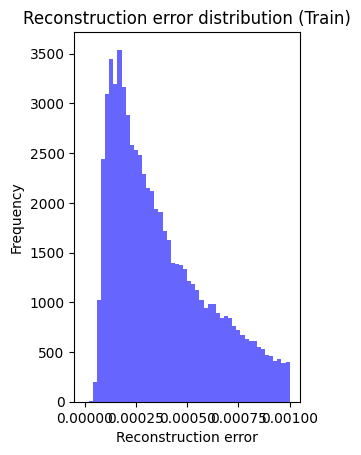

In [18]:
plt.subplot(1, 2, 1)
plt.hist(mse, bins=50, alpha=0.6,range=(0,0.001), color='blue')
plt.title('Reconstruction error distribution (Train)')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')

In [19]:
thresholds = np.linspace(0, 0.1, 100)
f1_scores = []
for thresh in thresholds:
    preds = [1 if e > thresh else 0 for e in mse]
    f1 = f1_score(Y_test, preds)
    f1_scores.append(f1)

In [20]:
max_f1 = max(f1_scores)
max_f1_threshold = thresholds[f1_scores.index(max_f1)]

In [21]:
max_f1_threshold

0.00909090909090909

In [22]:
predictions = [1 if e > max_f1_threshold else 0 for e in mse]

In [23]:
(len(predictions)),len(Y_test_withAnomalies)

(76898, 76898)

In [24]:
accuracy = accuracy_score(Y_test_withAnomalies, predictions)
f1 = f1_score(Y_test_withAnomalies, predictions)
precision = precision_score(Y_test_withAnomalies, predictions)
recall = recall_score(Y_test_withAnomalies, predictions)

print(f'Maximum F1 Score: {max_f1}')
print(f'Best Threshold: {max_f1_threshold}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Maximum F1 Score: 0.5766423357664233
Best Threshold: 0.00909090909090909
Accuracy: 0.9984915082316835
F1 Score: 0.5766423357664233
Precision: 0.5602836879432624
Recall: 0.5939849624060151


In [ ]:
predictionsDf = pd.DataFrame(X_test_WA_pred)

In [ ]:
predictionsDf["Mse"] = mse
predictionsDf["Prediction"] = predictions
predictionsDf["True"] = list(Y_test_withAnomalies)

In [ ]:
predictionsDf.to_csv("predictions.csv")